# Similarity analysis

We want to determine if the different batch simulated data is able to capture the biological signal that is present in the original data:  How much of the real input data is captured in the simulated batch data?

In other words, we want to ask: “do these datasets have similar patterns”?

To do this we will use a visual inspection using PCA

**Approach:**
1. Given Dataset A = simulated data with everything in 1 batch and Dataset B = simulated data with X batches, where X = 1,2,3,....
2. Plot PC1 vs PC2 of combined dataset A + B
3. Color samples by whether they are from A or B
4. Visually inspect the overlap between A and B

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
from plotnine import *
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Load config file
config_file = "config_exp_2.txt"

d = {}
float_params = ["learning_rate", "kappa", "epsilon_std"]
str_params = ["analysis_name", "NN_architecture"]
lst_params = ["num_batches"]
with open(config_file) as f:
    for line in f:
        (name, val) = line.split()
        if name in float_params:
            d[name] = float(val)
        elif name in str_params:
            d[name] = str(val)
        elif name in lst_params:
            d[name] = ast.literal_eval(val)
        else:
            d[name] = int(val)

In [3]:
# Parameters
analysis_name = d["analysis_name"]
NN_architecture = d["NN_architecture"]
num_batches = d["num_batches"]

In [4]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

batch_dir = os.path.join(
    base_dir,
    "data",
    "batch_simulated",
    analysis_name)

Plotting PCA of 1 batch vs 1 batches...
(12000, 5001)


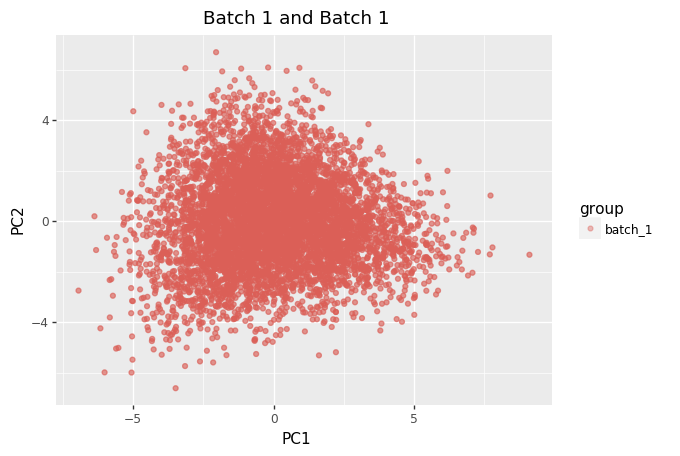

<ggplot: (-9223363249504367023)>
Plotting PCA of 1 batch vs 2 batches...
(12000, 5001)


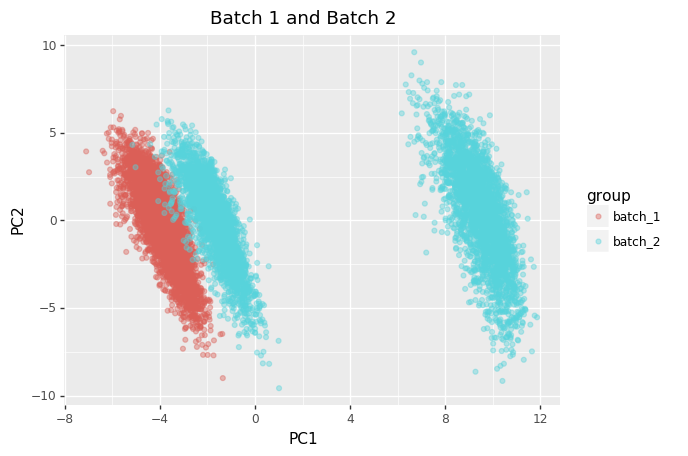

<ggplot: (-9223363249505068649)>
Plotting PCA of 1 batch vs 5 batches...
(12000, 5001)


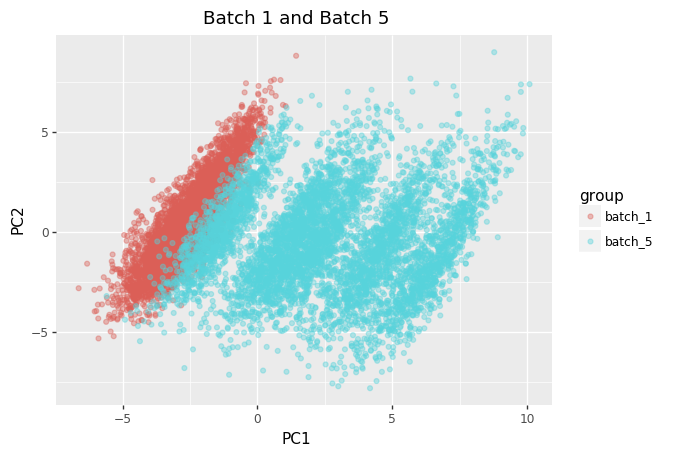

<ggplot: (8787393807217)>
Plotting PCA of 1 batch vs 10 batches...
(12000, 5001)


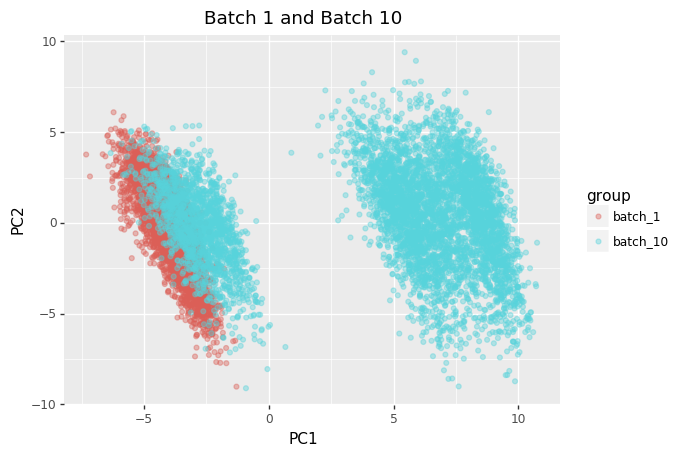

<ggplot: (-9223363249461170958)>
Plotting PCA of 1 batch vs 20 batches...
(12000, 5001)


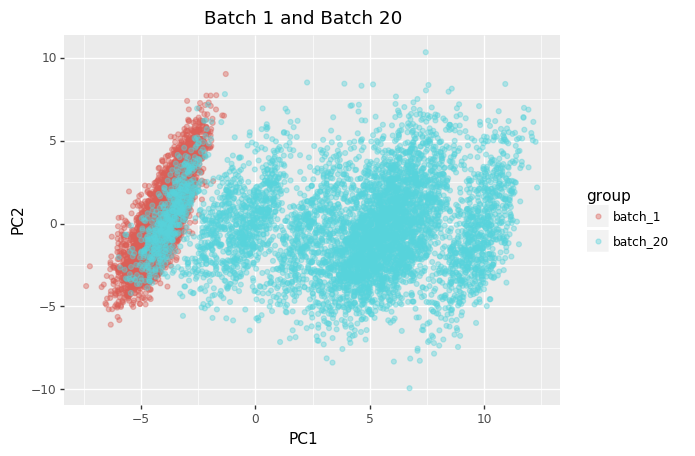

<ggplot: (8787346011256)>
Plotting PCA of 1 batch vs 50 batches...
(12000, 5001)


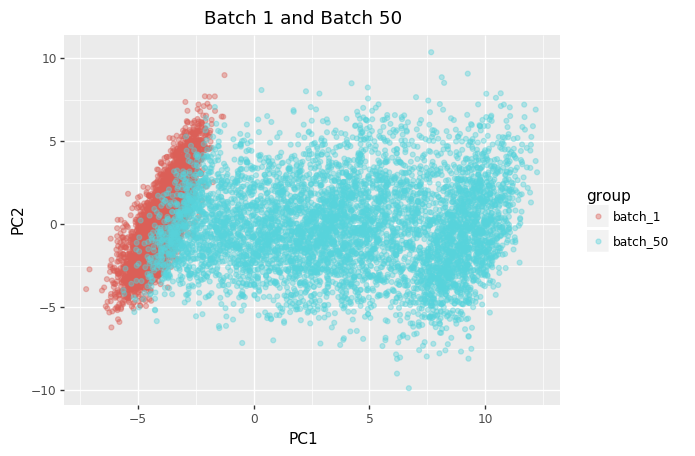

<ggplot: (8787346007893)>
Plotting PCA of 1 batch vs 100 batches...
(12000, 5001)


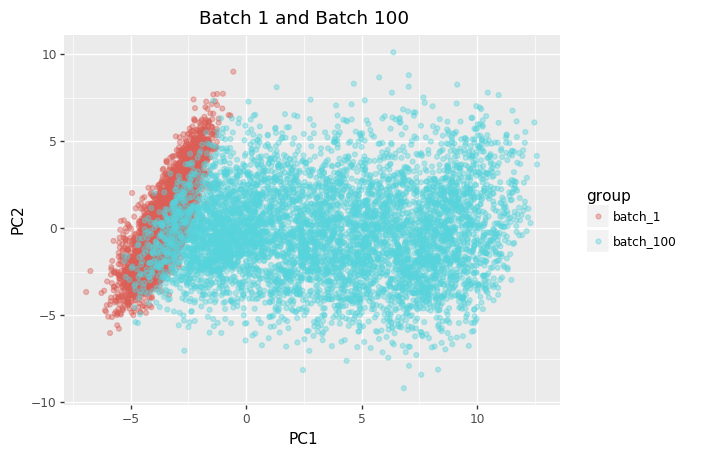

<ggplot: (8787393582470)>
Plotting PCA of 1 batch vs 500 batches...
(12000, 5001)


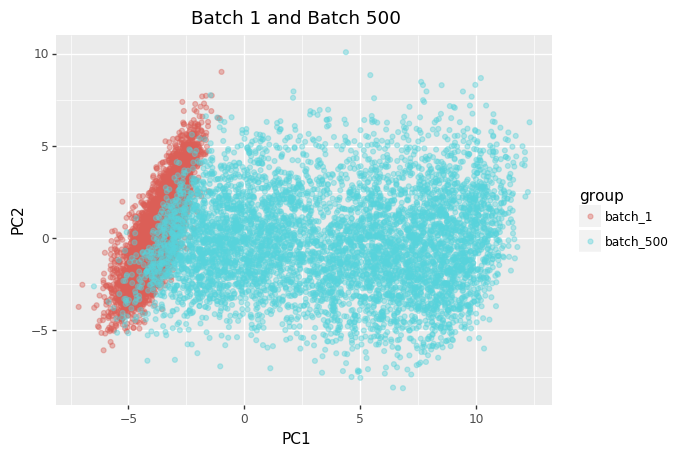

<ggplot: (8787345715513)>
Plotting PCA of 1 batch vs 1000 batches...
(12000, 5001)


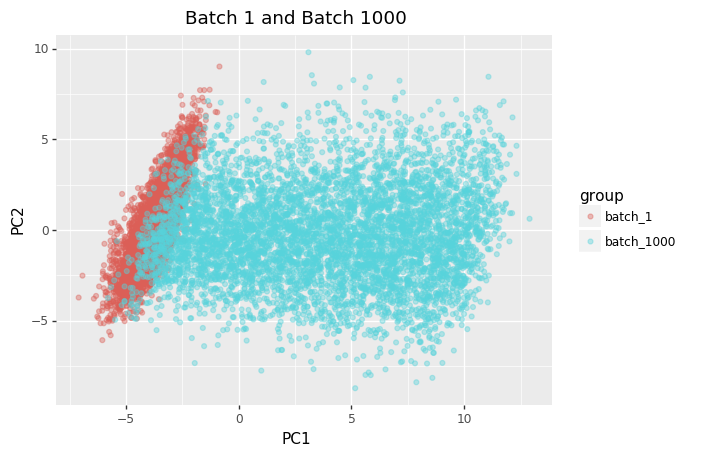

<ggplot: (-9223363249509060285)>
Plotting PCA of 1 batch vs 2000 batches...
(12000, 5001)


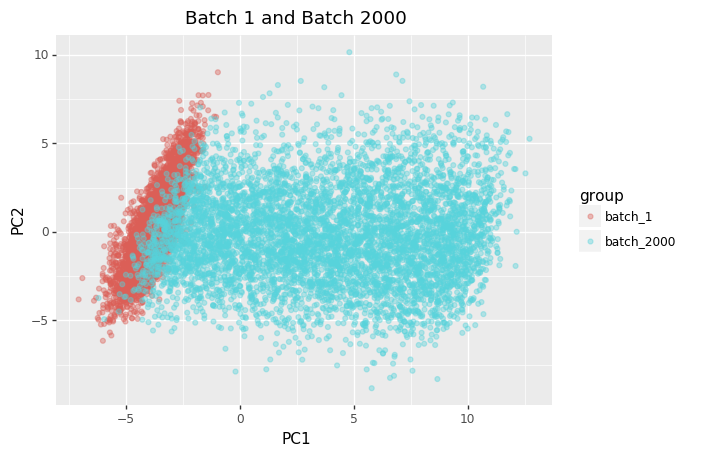

<ggplot: (-9223363249461209628)>
Plotting PCA of 1 batch vs 3000 batches...
(12000, 5001)


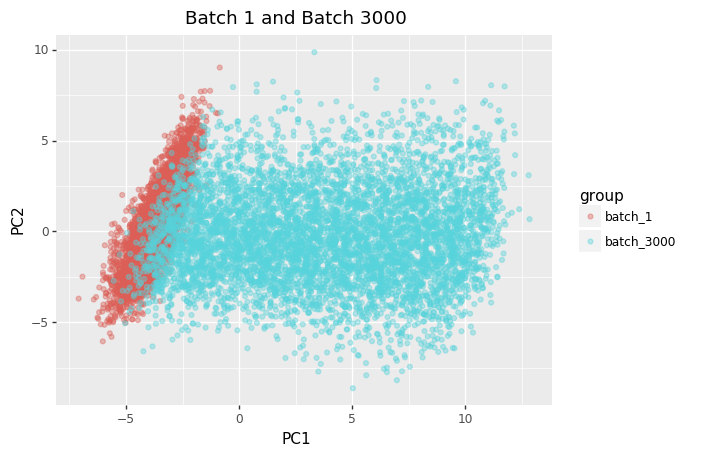

<ggplot: (-9223363249505153115)>
Plotting PCA of 1 batch vs 6000 batches...
(12000, 5001)


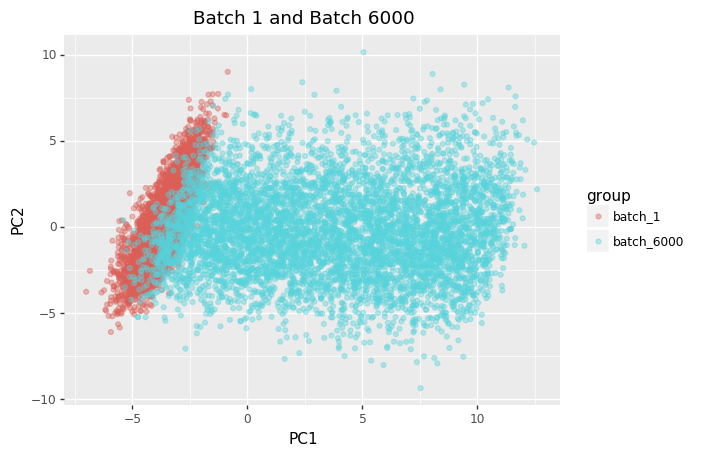

<ggplot: (-9223363249509188762)>
CPU times: user 8min 4s, sys: 52.3 s, total: 8min 56s
Wall time: 7min 33s


In [5]:
%%time

all_data_df = pd.DataFrame()

for i in num_batches:
    print('Plotting PCA of 1 batch vs {} batches...'.format(i))
    
    # Get batch 1 data
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt.xz")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        index_col=0,
        sep='\t')

    # Simulated data with all samples in a single batch
    original_data_df =  batch_1.copy()
    
    # Add grouping column for plotting
    original_data_df['group'] = 'batch_1'
    
    # Get data with additional batch effects added
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt.xz")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    batch_data_df =  batch_other
    
    # Add grouping column for plotting
    batch_data_df['group'] = "batch_{}".format(i)
    
    ## Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, batch_data_df])
    print(combined_data_df.shape)
    
    ## PCA projection
    pca = PCA(n_components=2)

    # Use trained model to encode expression data into SAME latent space
    combined_data_numeric_df = combined_data_df.drop(['group'], axis=1)
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)


    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
    
    # Add batch labels for the dataset that each sample belongs to (i.e. how many batches were added)
    combined_data_PCAencoded_df['group'] = combined_data_df['group']
    
    # Add column that designates which Batch effect comparision
    combined_data_PCAencoded_df['num_batches'] = str(i)
    
    # Concatenate all dataframes from each batch effect together
    all_data_df = pd.concat([all_data_df, combined_data_PCAencoded_df])
    
    
    # Plot
    print(ggplot(combined_data_PCAencoded_df, aes(x='PC1', y='PC2')) \
          + geom_point(aes(color='group'), alpha=0.4) \
          + xlab('PC1') \
          + ylab('PC2') \
          + ggtitle('Batch 1 and Batch {}'.format(i))
         )

In [6]:
# Permute simulated data
shuffled_simulated_arr = []
num_samples = batch_1.shape[0] ##can remove drop now?

for i in range(num_samples):
    row = list(batch_1.values[i])
    shuffled_simulated_row = random.sample(row, len(row))
    shuffled_simulated_arr.append(shuffled_simulated_row)

shuffled_simulated_data = pd.DataFrame(shuffled_simulated_arr, 
                                       index=batch_1.index,
                                       columns=batch_1.columns)
shuffled_simulated_data.head()

,5340,339,244,1567,1827,4981,2310,3929,1498,3226,...,2787,2526,3299,3097,5330,2854,494,5089,3662,1920
0,0.202026,0.738215,0.426413,0.438764,0.255176,0.195473,0.587439,0.242726,0.597092,0.256996,...,0.744417,0.399236,0.187995,0.730152,0.428255,0.505984,0.538293,0.299488,0.223218,0.492624
1,0.586084,0.744132,0.311065,0.441423,0.475908,0.526858,0.740156,0.251421,0.451944,0.148288,...,0.445960,0.586760,0.495927,0.306513,0.713376,0.241312,0.332789,0.362955,0.617589,0.142459
2,0.225381,0.142302,0.273688,0.513388,0.454962,0.472341,0.239904,0.454145,0.787892,0.440485,...,0.511755,0.786365,0.418634,0.503654,0.214949,0.332984,0.504520,0.186755,0.359725,0.407098
3,0.258374,0.317467,0.412700,0.300288,0.440261,0.388294,0.299930,0.341873,0.408061,0.449387,...,0.387081,0.199215,0.300415,0.553331,0.215601,0.318336,0.515621,0.558255,0.308550,0.387823
4,0.439352,0.640135,0.327103,0.476474,0.182953,0.697320,0.432862,0.381948,0.527024,0.421617,...,0.745728,0.248019,0.554368,0.180245,0.242365,0.337471,0.255455,0.414718,0.189325,0.363180


In [7]:
# PCA of permuted dataset (Negative control)

# Add batch labels for the dataset that each sample belongs to (i.e. how many batches were added)
shuffled_simulated_data['group'] = "permuted"

# Add to dataframe
input_vs_permuted_df = pd.concat([original_data_df, shuffled_simulated_data])


input_vs_permuted = input_vs_permuted_df.drop(['group'], axis=1)
shuffled_data_PCAencoded = pca.fit_transform(input_vs_permuted)


shuffled_data_PCAencoded_df = pd.DataFrame(shuffled_data_PCAencoded,
                                           index=input_vs_permuted_df.index,
                                           columns=['PC1', 'PC2']
                                          )

# Add batch labels for the dataset that each sample belongs to (i.e. how many batches were added)
shuffled_data_PCAencoded_df['group'] = input_vs_permuted_df['group']

In [8]:
shuffled_simulated_data.head()

,5340,339,244,1567,1827,4981,2310,3929,1498,3226,...,2526,3299,3097,5330,2854,494,5089,3662,1920,group
0,0.202026,0.738215,0.426413,0.438764,0.255176,0.195473,0.587439,0.242726,0.597092,0.256996,...,0.399236,0.187995,0.730152,0.428255,0.505984,0.538293,0.299488,0.223218,0.492624,permuted
1,0.586084,0.744132,0.311065,0.441423,0.475908,0.526858,0.740156,0.251421,0.451944,0.148288,...,0.586760,0.495927,0.306513,0.713376,0.241312,0.332789,0.362955,0.617589,0.142459,permuted
2,0.225381,0.142302,0.273688,0.513388,0.454962,0.472341,0.239904,0.454145,0.787892,0.440485,...,0.786365,0.418634,0.503654,0.214949,0.332984,0.504520,0.186755,0.359725,0.407098,permuted
3,0.258374,0.317467,0.412700,0.300288,0.440261,0.388294,0.299930,0.341873,0.408061,0.449387,...,0.199215,0.300415,0.553331,0.215601,0.318336,0.515621,0.558255,0.308550,0.387823,permuted
4,0.439352,0.640135,0.327103,0.476474,0.182953,0.697320,0.432862,0.381948,0.527024,0.421617,...,0.248019,0.554368,0.180245,0.242365,0.337471,0.255455,0.414718,0.189325,0.363180,permuted


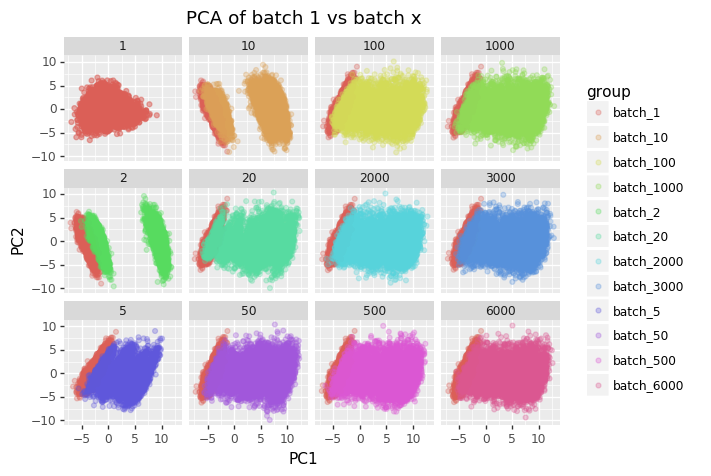

<ggplot: (-9223363249508302122)>

In [9]:
# Plot
ggplot(all_data_df, aes(x='PC1', y='PC2')) \
+ geom_point(aes(color='group'), alpha=0.3) \
+ facet_wrap('~num_batches') \
+ xlab('PC1') \
+ ylab('PC2') \
+ ggtitle('PCA of batch 1 vs batch x')

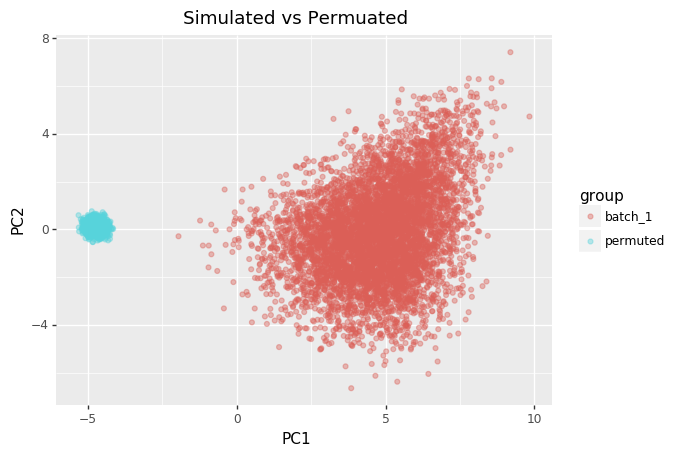

<ggplot: (-9223363249510300668)>


In [10]:
# Plot
print(ggplot(shuffled_data_PCAencoded_df, aes(x='PC1', y='PC2')) \
      + geom_point(aes(color='group'), alpha=0.4) \
      + xlab('PC1') \
      + ylab('PC2') \
      + ggtitle('Simulated vs Permuated')
     )